<h3>Objective</h3>
As discussed last time, my objective here is to do the following three things:
<ol>
<li>Look at doing k-fold cross validation
<li>Look at doing grid search to find better parameters
<li>Look at misclassified points to see patters for where the model is going wrong
</ol>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
def describe_dataset(dataset, dataset_name="given"):
    display(dataset.describe())
    cuisines = dataset.groupby("cuisine").count().sort("id", ascending=False)
    display(cuisines.head())
    i = range(cuisines.count().ingredients)
    plt.bar(i, cuisines.ingredients, label='Number of recipes in {} dataset'.format(dataset_name))
    plt.ylabel('total number of recipes')
    plt.title('Number of recipes by type of cuisine')
    plt.xticks(i, cuisines.index.values, rotation='vertical')
    plt.legend(loc='upper right')
    plt.show()

In [133]:
Training_data = pd.read_json("../input/whatscooking/train.json")
Training_data['str_ingredients'] = Training_data.ingredients.apply(lambda x: ','.join(y for y in x))
#describe_dataset(Training_data, "Training");
Testing_data = pd.read_json("../input/whatscooking/test.json")
Testing_data['str_ingredients'] = Testing_data.ingredients.apply(lambda x: ','.join(y for y in x))

In [4]:
import itertools
grouped_ingredients = itertools.groupby(sorted(list(itertools.chain.from_iterable(Training_data.ingredients))))
ingredient_counts = {key:len(list(group)) for key, group in grouped_ingredients}
global_pantry = pd.DataFrame.from_dict(ingredient_counts, orient='index')
global_pantry.columns = ['num_recipes']
display(global_pantry.count())
global_pantry.head()

num_recipes    6714
dtype: int64

,num_recipes
low-sodium fat-free chicken broth,22
sweetened coconut,3
baking chocolate,3
egg roll wrappers,57
bottled low sodium salsa,1


In [27]:
Y_Train = Training_data.cuisine
from sklearn.cross_validation import StratifiedKFold
stratifiedKFolds = StratifiedKFold(Y_Train, n_folds=10)
len(stratifiedKFolds)

10

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

folds = []
for train, test in stratifiedKFolds:
    train = Training_data.iloc[train]
    test = Training_data.iloc[test]
    vectorizer = TfidfVectorizer(sublinear_tf=True, vocabulary=global_pantry.index.values)
    X_train = vectorizer.fit_transform(train.str_ingredients)
    feature_names = vectorizer.get_feature_names()
    feature_names = np.asarray(feature_names);
    X_test = vectorizer.transform(test.str_ingredients)
    y_train = train.cuisine
    y_test = test.cuisine
    X_Test = vectorizer.transform(Testing_data.str_ingredients)
    folds.append((X_train, y_train, X_test, y_test, feature_names, X_Test))
len(folds)

10

In [52]:
from sklearn.utils.extmath import density
from sklearn import metrics
from time import time

def benchmark(name, classifier_generator, verbose=False):
    fold_classifiers = []
    scores = []
    train_times = []
    test_times = []
    
    for fold in folds:
        classifier = classifier_generator()
        X_train = fold[0]
        y_train = fold[1]
        X_test = fold[2]
        y_test = fold[3]
        feature_names = fold[4]
        
        t0 = time()
        classifier.fit(X_train, y_train)
        train_time = time() - t0

        t0 = time()
        predictions = classifier.predict(X_test)
        test_time = time() - t0

        score = metrics.accuracy_score(y_test, predictions)
        
        fold_classifiers.append(classifier)
        scores.append(score)
        train_times.append(train_time)
        test_times.append(test_time)
        
        if verbose and hasattr(classifier, 'coef_'):
            print "Dimensionality: {}".format(classifier.coef_.shape[1])
            print "Density: {}".format(density(classifier.coef_))

            print "top10 features for each category:"
            for i, category in enumerate(classifier.classes_):
                top10 = np.argsort(classifier.coef_[i])[-10:]
                print("%s: %s" % (category, " ".join(feature_names[top10])))

            print "classification report:"
            print metrics.classification_report(y_test, predictions)

            print "confusion matrix:"
            print metrics.confusion_matrix(y_test, predictions)
    
    mean_score = np.mean(scores)
    mean_train_time = np.mean(train_times)
    mean_test_time = np.mean(test_time)
    print "Number of classifiers: {}, Accuracy: {}, Train time: {}, Test time: {}".format(
        len(fold_classifiers), mean_score, mean_train_time, mean_test_time)
    return name, fold_classifiers, mean_score, mean_train_time, mean_test_time

In [53]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
classifiers = [
    ("LinearSVC_L2", lambda : LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3)),
    ("RandomForestClassifier_200", lambda : RandomForestClassifier(n_estimators=200)),
    ("SVC_linear", lambda : SVC(kernel='linear')),
    ("SVC_rbf", lambda : SVC(kernel='rbf')),
    ("Pipeline_LinearSVC_L2_Linear", lambda : Pipeline([
        ('feature_selection', LinearSVC(penalty="l2", dual=False, tol=1e-3)),
        ('classification', LinearSVC())
    ])),
]

results = []
for name, classifier_generator in classifiers:
    print "Training: {}".format(name)
    results.append(benchmark(name, classifier_generator))

Training: LinearSVC_L2
Number of classifiers: 10, Accuracy: 0.739227061136, Train time: 4.57656610012, Test time: 0.00167298316956
Training: RandomForestClassifier_200
Number of classifiers: 10, Accuracy: 0.740780957398, Train time: 178.465523958, Test time: 2.74601888657
Training: SVC_linear
Number of classifiers: 10, Accuracy: 0.74375461674, Train time: 80.345841217, Test time: 10.7507610321
Training: SVC_rbf
Number of classifiers: 10, Accuracy: 0.197063754711, Train time: 283.329858208, Test time: 21.7943429947
Training: Pipeline_LinearSVC_L2_Linear
Number of classifiers: 10, Accuracy: 0.73915184223, Train time: 7.0807015419, Test time: 0.0138640403748


In [55]:
results;

In [57]:
sorted_results = sorted(results, key=lambda x: x[2])
sorted_results;

In [59]:
rearranged_results = [[x[i] for x in sorted_results] for i in range(5)]
rearranged_results;

In [60]:
indices = np.arange(len(results))
clf_names, classifiers, scores, train_times, test_times = rearranged_results

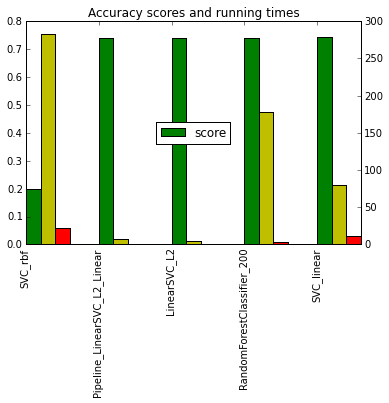

In [62]:
plt.title("Accuracy scores and running times")
width = 0.2
plt.bar(indices, scores, width, label="score", color='g')
plt.legend(loc='center')
plt.xticks(indices, clf_names, rotation='vertical')
plt.twinx()
plt.bar(indices+width, train_times, width, label="train_time", color='y')
plt.bar(indices+(2*width), test_times, width, label="test_time", color='r')
plt.show()

In [116]:
chosen_classifier_set = classifiers[-3]
chosen_classifier_set

[LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
      verbose=0),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
      verbose=0),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
      verbose=0),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
      verbose=0),
 LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', ma

In [117]:
Predicted_data = Testing_data.copy()
for iter, classifier in enumerate(chosen_classifier_set):
    X_Test = folds[iter][-1]
    predictions = classifier.predict(X_Test)
    Predicted_data['fold{}_pred'.format(iter)] = predictions
Predicted_data.head()

,id,ingredients,str_ingredients,fold0_pred,fold1_pred,fold2_pred,fold3_pred,fold4_pred,fold5_pred,fold6_pred,fold7_pred,fold8_pred,fold9_pred
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","baking powder,eggs,all-purpose flour,raisins,m...",irish,british,british,british,british,british,irish,british,british,british
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","sugar,egg yolks,corn starch,cream of tartar,ba...",southern_us,southern_us,southern_us,southern_us,southern_us,southern_us,southern_us,southern_us,southern_us,southern_us
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","sausage links,fennel bulb,fronds,olive oil,cub...",italian,italian,italian,italian,italian,italian,italian,italian,italian,italian
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","meat cuts,file powder,smoked sausage,okra,shri...",cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole,cajun_creole
4,35687,"[ground black pepper, salt, sausage casings, l...","ground black pepper,salt,sausage casings,leeks...",italian,italian,italian,italian,italian,italian,italian,italian,italian,italian


In [134]:
# cuisine = Predicted_data['fold0_pred', 'fold1_pred'].mode(axis=1, numeric_only=False)
# cuisine
majority_vote = Predicted_data[['fold0_pred', 
                'fold1_pred', 
                'fold2_pred', 
                'fold3_pred', 
                'fold4_pred', 
                'fold5_pred', 
                'fold6_pred', 
                'fold7_pred', 
                'fold8_pred', 
                'fold9_pred']].mode(axis=1, numeric_only=False)
column_names = ['cuisine']
for i in range(2, majority_vote.shape[1]+1):
    column_names.append('cuisine_{}'.format(i))
majority_vote.columns = column_names
display(majority_vote.describe())
print majority_vote.shape
#display(majority_vote.head())
#display(majority_vote[majority_vote.cuisine_2.notnull()].head())
#display(majority_vote[majority_vote.cuisine.notnull()].head())

,cuisine,cuisine_2,cuisine_3
count,9944,66,1
unique,20,14,1
top,italian,italian,irish
freq,2148,16,1


(9944, 3)


In [131]:
merged_data = pd.concat([Predicted_data, majority_vote], axis=1)
merged_data[['id', 'cuisine']].head()

,id,cuisine
0,18009,british
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian


In [132]:
submission = merged_data[['id', 'cuisine']]
import time
submission.to_csv('../output/whatscooking/whatscooking-{}.csv'.format(time.strftime("%Y%m%d--%H%M%S")), index=False)